# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [85]:
# import libraries
#import torch
import numpy as np
import matplotlib.pyplot as plt

In [69]:
"""Load from /home/USER/data/mnist or elsewhere; download if missing."""

import gzip
import os
from urllib.request import urlretrieve
import numpy as np


def mnist(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    url = 'http://yann.lecun.com/exdb/mnist/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']

    if path is None:
        # Set path to /home/USER/data/mnist or C:\Users\USER\data\mnist
        path = os.path.join(os.path.expanduser('~'), 'data', 'mnist')

    # Create path if it doesn't exist
    os.makedirs(path, exist_ok=True)

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))
    print("All files are ready to gzip!")

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 1, 28, 28).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)
        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)
    print("Train Images : Loading . . .")
    train_images = _images(os.path.join(path, files[0]))
    print("Train Labels : Loading . . .")
    train_labels = _labels(os.path.join(path, files[1]))
    print("Test Images  : Loading . . .")
    test_images = _images(os.path.join(path, files[2]))
    print("Test Labels  : Loading . . .")
    test_labels = _labels(os.path.join(path, files[3]))
    print("Done!")

    return train_images, train_labels, test_images, test_labels

In [70]:
train_images, train_labels, test_images, test_labels = mnist()

All files are ready to gzip!
Train Images : Loading . . .
Train Labels : Loading . . .
Test Images  : Loading . . .
Test Labels  : Loading . . .
Done!


In [71]:
ch = 1 #Number of channels
print(train_images.shape)
print(train_labels.shape) # ONE-HOT !!!
#print(train_images.T.shape)
#print(train_labels.reshape((train_images.shape[0], 10)).shape)

##### Getting Ready for the Conv Layers #####
#train_images = train_images.reshape(train_images.shape[0], ch, 28, 28).squeeze()
#test_images = test_images.reshape(test_images.shape[0], ch, 28, 28).squeeze()

#############################################

y = train_images[1].reshape(1,28,28)
#print(y.squeeze().shape)
'''
temp = []
#train_labels = train_labels.sum(1)
for i in range(int(len(train_labels[:]))):
    temp.append(list(train_labels[i][:]).index(1))
    
    
train_labels = np.array(temp.copy())
#print(train_labels[0:5])
'''
pass

(60000, 1, 28, 28)
(60000, 10)


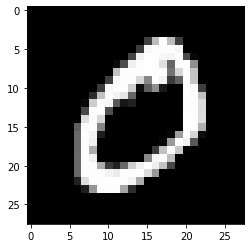

In [72]:
plt.imshow(y.squeeze(), cmap='Greys_r');

In [130]:
###### Architecture ######

NN_ARCHITECTURE = [
    {"input_dim": 800, "output_dim": 512, "activation": "relu"},
    {"input_dim": 512, "output_dim": 10, "activation": "sigmoid"} #Or relu again like the original example
]#No Dropout...yet


######  Init Layers  ######

def init_layers(nn_architecture, seed = 99):
    # random seed initiation
    np.random.seed(seed)
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # parameters storage initiation
    params_values = {}

    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1

        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]

        # initiating the values of the W matrix
        # and vector b for subsequent layers
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1

    return params_values

In [131]:
### Activation Functions ###
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

In [132]:
def conv(image, params, s): # s = 1 (conv stride)
    #f1 shape : (num_filters,input channels, f_h, f_w)
    #image shape: (channels, height, width)
    [f, b] = params
    f_depth = f.shape[1] #f1 = 1 , f2 = 8
    f_size = f.shape[2] #5x5
    f_num = f.shape[0]
    
    h_range = int((image.shape[1] - f_size) / s) + 1     # (W - F + 2P) / S  
    w_range = int((image.shape[2] - f_size) / s) + 1     # (W - F + 2P) / S  
    np_o = np.zeros((f_num, h_range, w_range))
    for z in range(f_num): # Number of filters
        for _h in range(h_range):      
            for _w in range(w_range):
                np_o[z, _h, _w] = np.sum(image[:, _h*s : _h*s + f_size, _w*s : _w*s + f_size] * f[z, :, :, :]) + b[z]
    
    return np_o

def convolutionBackward(dconv_prev, conv_in, filt, s):
    f_num, n_c, f, _ = filt.shape
    
    _ ,h , w = dconv_prev.shape
    dfilt = np.zeros(filt.shape)
    dconv_in = np.zeros(conv_in.shape)
    db = np.zeros((f_num,1))

    for z in range(f_num): # Number of filters
        for _h in range(h):      
            for _w in range(w):
                #each entry of the dconv_prev will try to affect the idxs from which was made of.
                dfilt[z] += dconv_prev[z, _h, _w] * conv_in[:, _h*s : _h*s + f, _w*s : _w*s + f]
                dconv_in[:, _h*s : _h*s + f, _w*s : _w*s + f] += dconv_prev[z, _h, _w] * filt[z]  
        db[z] = np.sum(dconv_prev[z])  #, axis =1) ## AXIS?
    return dconv_in, dfilt, db



def maxpool(image, f=2 , s=2):
    
    h_range = int((image.shape[1] - f) / s) + 1     # (W - F + 2P) / S  
    w_range = int((image.shape[2] - f) / s) + 1     # (W - F + 2P) / S 
    out = np.zeros((image.shape[0], h_range, w_range))
    
    for z in range(image.shape[0]): # Number of channels
        for _h in range(h_range):      
            for _w in range(w_range):
                out[z, _h, _w] = np.max(image[z, _h*s : _h*s + f, _w*s : _w*s + f])
    return out

def nanargmax(arr):
    #print(arr.shape)
    try:
        idx = np.nanargmax(arr)
        #print (idx)
    except:
        idx = 0
    idxs = np.unravel_index(idx, arr.shape)
    return idxs 

def maxpoolBackward(dpool, conv, f=2 , s=2):
    num_c, h, w = conv.shape
    h = int((h - f) / s) + 1     # (W - F + 2P) / S  
    w = int((w - f) / s) + 1     # (W - F + 2P) / S 
    
    dout = np.zeros(conv.shape)
    #print(conv.shape)
    for z in range(num_c): # Number of channels
        for _h in range(h):      
            for _w in range(w):
                (a, b) = nanargmax(conv[z, _h*s : _h*s + f, _w*s : _w*s + f]) #Getting the indexes from the max value in this area
                #put it on the new array
                dout[z, _h + a, _w + b] = dpool[z, _h, _w]
    
    
    return dout

In [161]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    
    # calculation of the input value for the activation function
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # selection of activation function
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    # return of calculated activation A and the intermediate Z matrix
    return activation_func(Z_curr), Z_curr

def full_forward_propagation(X,filter_params ,params_values, nn_architecture, dropout):
    
    ######################## Forward Propagation Convolution Part  ##########################
    [f1, f2, b1, b2] = filter_params
    
    params = [f1, b1]
    conv1 = conv(X, params, 1)   #conv1 shape = (num_channels, h, w)
    conv1[conv1<=0] = 0 #Relu
    
    params = [f2, b2]
    conv2 = conv(conv1, params, 1)
    conv2[conv2<=0] = 0 #Relu
    
    pl = maxpool(conv2, 2, 2) #pool_f = 2 , pool_s = 2
    
    #packet
    conv_mem = [X, conv1, conv2, pl]
    
    num_c, f_dim, _ = pl.shape
    fc1 = pl.reshape(num_c*f_dim*f_dim, 1) #Flattening

    
    ######################## Forward Propagation FC Part  ##########################
    
    
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = fc1
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        # extraction of W for the current layer
        W_curr = params_values["W" + str(layer_idx)]
        if ((layer_idx == 1)and(dropout)):
                ## Dropout ##
                d = (np.random.rand(W_curr.shape[0],W_curr.shape[1])<0.5)
                d = d*1 #Bool --> int(0s and 1s)
                W_curr = d*W_curr
                #############
            
        # extraction of b for the current layer
        b_curr = params_values["b" + str(layer_idx)]
        # calculation of activation for the current layer
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # return of prediction vector and a dictionary containing intermediate values
    return A_curr, conv_mem, memory

In [162]:
###### Cost Calculations ######
def NLLLoss(logs, targets):
    out = []
    #print(len(targets))
    for i in range(len(targets)):
        out.append(logs[i][targets[i]])
    out = np.array(out)
    
    return -out.sum()/len(out)

def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost) ### ATTENTION!


###### Accuracy Calculation ######

# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_


def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

In [163]:
#######  BACK PROPAGATION  #######

def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # number of examples
    m = A_prev.shape[1]
    
    # selection of activation function
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')

    # calculation of the activation function derivative
    
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # derivative of the matrix W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    
    # derivative of the vector b
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # derivative of the matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr 


def full_backward_propagation(Y_hat, Y, conv_mem, memory, filter_params, params_values, nn_architecture):
    
    
    ################# Backwardpropagation for FC Part  #######################
    grads_values = {}
    
    # number of examples
    #print(Y.shape)
    m = Y.shape[1]     # 1 sample each time
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # initiation of gradient descent algorithm
    dA_prev = Y_hat - Y#- (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)

        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    ################# Backwardpropagation for Conv Part  #######################
    [f1, f2, b1, b2] = filter_params
    [image_in, conv1, conv2, pl]= conv_mem
    #dA_prev
    #Find dimensions of pooled image
    #dim = int(np.sqrt(dA_prev.shape(0)/f2.shape(0))) #sqrt(800/8)=10 ==> 8*10*10
    dpool = dA_prev.reshape(pl.shape) #, 1) 
    dconv2 = maxpoolBackward(dpool, conv2)  # , pool_f, pool_s)
    dconv2[conv2<=0] = 0 # backpropagate through ReLU
    
    conv_s = 1
    dconv1, df2, db2 = convolutionBackward(dconv2, conv1, f2, conv_s) #
    dconv1[conv1<=0] = 0
    
    _, df1, db1 = convolutionBackward(dconv1, image_in, f1, conv_s)
    
    conv_grads = [df1, df2, db1, db2] 
    
    return conv_grads, grads_values

In [164]:
###### UPDATE ######

def update(params_values, grads_values, nn_architecture, learning_rate):

    # iteration over network layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

In [165]:
######  TRAIN  ######
#import torch
import time
time.time()


def train(X, Y, nn_architecture, epochs, learning_rate, dropout, verbose=True, callback=None):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    
    
    ####### Building index labels from One-Hot matrix #######
    temp = []
    #train_labels = train_labels.sum(1)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if(Y[i][j]==1):
                temp.append(j)
    #########################################################
    
    ##filter params
    num_f1 = 8
    num_f2 = 8
    f_dim = 5
    f1 = (num_f1, 1, f_dim, f_dim )
    f2 = (num_f2, num_f1, f_dim, f_dim )
    #To make for a smoother training process, we initialize each filter with a mean of 0 and a standard deviation of 1
    scale = 1.0
    #stddev = scale/np.sqrt(np.prod(f1))
    trim = 0.1
    f1 = np.random.randn( num_f1, 1, f_dim, f_dim) *trim
    stddev = scale/np.sqrt(np.prod(f2))
    f2 = np.random.randn(num_f2, num_f1, f_dim, f_dim ) *trim
    b1 = np.random.randn(f1.shape[0],1)* trim
    b2 = np.random.randn(f2.shape[0],1)* trim
    #Packing Conv params
    filter_params = []
    filter_params = (f1, f2, b1, b2)

    
    #f1 shape : (num_filters,input channels, f_h, f_w)
    #image shape: (channels, height, width)
    
    # performing calculations for subsequent iterations
    for e in range(epochs):
        # step forward
        running_loss = 0
        accuracy = 0
        batch = 12
        print("Epoch: {%d}" %(e+1))
        for c in range(0, X.shape[0], batch):
            
            #### Reset Gradients (Every batch) ####
            
            df1 = np.zeros(f1.shape)
            df2 = np.zeros(f2.shape)
            db1 = np.zeros(b1.shape)
            db2 = np.zeros(b2.shape)
            dW1 = np.zeros(params_values['W1'].shape)
            dW2 = np.zeros(params_values['W2'].shape)
            dB1 = np.zeros(params_values['b1'].shape)
            dB2 = np.zeros(params_values['b2'].shape)
            
            
            
            ######################################
            
            
            #timestamp1 = time.time()
            
            if(X.shape[0] - c < batch):#means that there is a smaller(<32) part left
                batch = X.shape[0] - c
            X_t = X[c:(c + batch)]  # shape:(m, ch, h, w)
            Y_t = Y[c:(c + batch)]
            Ys  = np.array(temp[c:(c + batch)]).reshape(batch,1) #shape (m,1), NOT one-hot
            cost = 0
            accuracy = 0
            
            for b in range(batch):
                
                
                # 1 image per time...for now
                Y_hat, conv_mem, cashe = full_forward_propagation(X_t[b], filter_params, params_values, nn_architecture, dropout)
            
            
                       
                Yh = np.array(Y_hat.T)

                ############### LogSoftMax  #################
                #x_log=np.log( np.exp(Yh) / np.sum(np.exp(Yh), axis = 1) )  #(60000,10) , we need to add along columns so we get sum of 1 on every example-row
                num = np.exp(Yh)
                den = np.sum(np.exp(Yh), axis = 1)

                for i in range(Yh.shape[0]): #1  , just 1 per time
                    #for j in range(Yh.shape[1]): #10
                    Yh[i][:] = np.log(num[i][:] / den[i])  
                #############################################
            
                #print(Yh.shape)
                #print(len(Ys))                
                cost += NLLLoss(Yh, np.array(Ys[b]))  #(we need to send image(samples,classes), labels(NOT in one-hot) - Future optimizations needed)
                #print("Cost: {%f}" %(cost))
                
                
                
                accuracy += get_accuracy_value(Y_hat, Y_t[b].reshape(10,1))
                
                conv_grads, grads_values = full_backward_propagation(Y_hat, Y_t[b].reshape(Y_t[b].shape[0],1), conv_mem, cashe, filter_params, params_values, nn_architecture)
                [df1_, df2_, db1_, db2_] = conv_grads

                df1 += df1_
                df2 += df2_
                db1 += db1_
                db2 += db2_

                dW1 +=  grads_values['dW1']
                dW2 +=  grads_values['dW2']
                dB1 += grads_values['db1']
                dB2 += grads_values['db2']
                
            
            
            #Updating Conv Part
            

            #print(Yh)
            #print(t)
            print(c)
            

            f1 -= (learning_rate) * (df1/batch)
            f2 -= (learning_rate) * (df2/batch)
            b1 -= (learning_rate) * (db1/batch)
            b2 -= (learning_rate) * (db2/batch)
            filter_params = [f1, f2, b1, b2]
                
            # updating FC Part
            #params_values = update(params_values, grads_values, nn_architecture, learning_rate)
            grads_values['dW1'] = dW1#/(batch)
            grads_values['dW2'] = dW2#/(batch)
            grads_values['db1'] = dB1#/(batch)
            grads_values['db2'] = dB2#/(batch)
                   
            for layer_idx, layer in enumerate(nn_architecture, 1):
                
                params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
                params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

            print("Cost : {:.5f}".format(cost/batch))
            print("Accuracy : {:.5f}%".format((accuracy*100)/batch))
            
        #END OF LOOP - EPOCH
        #timestamp2 = time.time()
        #print ("This took %.2f seconds" %(timestamp2 - timestamp1))
        if(verbose):
            print("Epoch: {:5d}   -   cost: {:.2f}   -   Accuracy: {:.2f}%".format(e+1, cost/batch, (accuracy*100)/batch))
        #if(callback is not None):
        #    callback(i, params_values)
            
    return params_values

In [166]:
###### Training ######
#train_images, train_labels, test_images, test_labels
import gc
gc.collect()

params_values = train(train_images, train_labels, NN_ARCHITECTURE, 2, 0.05, True) #0.05 stable LR

Epoch: {1}
0
Cost : 2.33194
Accuracy : 0.00000%
12
Cost : 2.31712
Accuracy : 0.00000%
24
Cost : 2.30183
Accuracy : 0.00000%
36
Cost : 2.30091
Accuracy : 0.00000%
48
Cost : 2.28860
Accuracy : 0.00000%
60
Cost : 2.26492
Accuracy : 0.00000%
72
Cost : 2.28164
Accuracy : 0.00000%
84
Cost : 2.30385
Accuracy : 0.00000%
96
Cost : 2.24933
Accuracy : 0.00000%
108
Cost : 2.27358
Accuracy : 0.00000%
120
Cost : 2.26518
Accuracy : 8.33333%
132
Cost : 2.29471
Accuracy : 0.00000%
144
Cost : 2.29439
Accuracy : 0.00000%
156
Cost : 2.28338
Accuracy : 0.00000%
168
Cost : 2.25080
Accuracy : 0.00000%
180
Cost : 2.28764
Accuracy : 0.00000%
192
Cost : 2.24895
Accuracy : 0.00000%
204
Cost : 2.18171
Accuracy : 8.33333%
216
Cost : 2.29403
Accuracy : 0.00000%
228
Cost : 2.22957
Accuracy : 8.33333%
240
Cost : 2.22705
Accuracy : 8.33333%
252
Cost : 2.20576
Accuracy : 8.33333%
264
Cost : 2.24490
Accuracy : 8.33333%
276
Cost : 2.22385
Accuracy : 8.33333%
288
Cost : 2.21398
Accuracy : 8.33333%
300
Cost : 2.22582
Accur

2448
Cost : 2.02653
Accuracy : 25.00000%
2460
Cost : 1.93662
Accuracy : 33.33333%
2472
Cost : 1.97468
Accuracy : 50.00000%
2484
Cost : 1.87226
Accuracy : 66.66667%
2496
Cost : 1.85995
Accuracy : 66.66667%
2508
Cost : 1.96327
Accuracy : 41.66667%
2520
Cost : 1.90053
Accuracy : 66.66667%
2532
Cost : 1.88664
Accuracy : 41.66667%
2544
Cost : 2.14152
Accuracy : 25.00000%
2556
Cost : 1.95513
Accuracy : 50.00000%
2568
Cost : 1.93596
Accuracy : 50.00000%
2580
Cost : 1.88369
Accuracy : 58.33333%
2592
Cost : 1.92467
Accuracy : 50.00000%
2604
Cost : 1.91836
Accuracy : 50.00000%
2616
Cost : 1.86715
Accuracy : 75.00000%
2628
Cost : 1.84034
Accuracy : 66.66667%
2640
Cost : 1.83350
Accuracy : 66.66667%
2652
Cost : 1.89933
Accuracy : 75.00000%
2664
Cost : 1.92966
Accuracy : 41.66667%
2676
Cost : 2.06111
Accuracy : 25.00000%
2688
Cost : 1.92810
Accuracy : 58.33333%
2700
Cost : 1.84986
Accuracy : 58.33333%
2712
Cost : 2.00372
Accuracy : 41.66667%
2724
Cost : 1.93902
Accuracy : 41.66667%
2736
Cost : 1.92

4848
Cost : 1.82503
Accuracy : 58.33333%
4860
Cost : 1.72900
Accuracy : 75.00000%
4872
Cost : 1.71206
Accuracy : 83.33333%
4884
Cost : 1.73144
Accuracy : 75.00000%
4896
Cost : 1.66758
Accuracy : 91.66667%
4908
Cost : 1.81331
Accuracy : 66.66667%
4920
Cost : 1.66478
Accuracy : 83.33333%
4932
Cost : 1.78501
Accuracy : 58.33333%
4944
Cost : 1.78172
Accuracy : 58.33333%
4956
Cost : 1.84054
Accuracy : 66.66667%
4968
Cost : 1.75377
Accuracy : 75.00000%
4980
Cost : 1.77204
Accuracy : 75.00000%
4992
Cost : 1.78741
Accuracy : 66.66667%
5004
Cost : 1.73328
Accuracy : 75.00000%
5016
Cost : 1.69641
Accuracy : 75.00000%
5028
Cost : 1.93555
Accuracy : 33.33333%
5040
Cost : 1.83865
Accuracy : 58.33333%
5052
Cost : 1.83707
Accuracy : 50.00000%
5064
Cost : 1.76971
Accuracy : 58.33333%
5076
Cost : 1.91231
Accuracy : 58.33333%
5088
Cost : 1.68355
Accuracy : 66.66667%
5100
Cost : 1.68760
Accuracy : 83.33333%
5112
Cost : 1.56928
Accuracy : 91.66667%
5124
Cost : 1.73000
Accuracy : 66.66667%
5136
Cost : 1.75

KeyboardInterrupt: 

In [ ]:
###### Prediction ######
Yt = test_labels.T
temp1 = []
for i in range(Yt.shape[1]):
        for j in range(Yt.shape[0]):
            if(Yt[j][i]==1):
                temp1.append(j)
Yt=np.array(temp1)
Y_test_hat, _ = full_forward_propagation(np.transpose(test_images), params_values, NN_ARCHITECTURE)#multiple?!

Yht = np.array(Y_test_hat.T)
#x_log=np.log( np.exp(Yh) / np.sum(np.exp(Yh), axis = 1) )  #(60000,10) , we need to add along columns so we get sum of 1 on every example-row
num = np.exp(Yht)
den = np.sum(np.exp(Yht), axis = 1)
for i in range(Yht.shape[0]): #60000
                #for j in range(Yh.shape[1]): #10
                Yht[i][:] = np.log(num[i][:] / den[i])  

#cost = get_cost_value(Yht, Yt)

#cost_history.append(cost)
accuracy = get_accuracy_value(Y_test_hat, test_labels.T)
#accuracy_history.append(accuracy)
print("Accuracy: {:.5f}%".format( accuracy*100))